# Today's Dataset

..... 20 newsgroups!

In [1]:
from sklearn.datasets import fetch_20newsgroups

# new categories!!
cats = ['comp.sys.mac.hardware', 'rec.motorcycles', 'rec.sport.baseball', 
        'sci.electronics', 'sci.med', 'talk.politics.guns', 'talk.religion.misc']

all_data = fetch_20newsgroups(subset='all', categories=cats)
train_set = fetch_20newsgroups(subset='train', categories=cats)
test_set = fetch_20newsgroups(subset='test', categories=cats)



First we will turn the provided train/test sets into tf-idf vectors.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=3, stop_words='english')

X_train = vectorizer.fit_transform(train_set.data)
y_train = train_set.target

# Prepare test data. Only transformation needed. 
X_test = vectorizer.transform(test_set.data)
y_test = test_set.target


# the Problem of Overfitting




![alt text](https://cdn-images-1.medium.com/max/1600/1*SBUK2QEfCP-zvJmKm14wGQ.png)

The model fits to small, irrelevant intricacies in the dataset and has good performance, but does not generalize well.

Common signs of overfitting:
* Significantly better performance on training set than on testing set
* Worse than expected performance

Many ways to deal with this, but a few are:
* getting more data
* dimensionality reduction
* cross validation

# Dimensionality Reduction


Problems with high-dimension features:

* Higher risk of overfitting to sparse data
* Redundant correlated variables
*  Computationally intensive

Solution: use fewer dimensions! (This does not necessarily eliminate overfitting)

## Principal Component Analysis (PCA)
One form of dimensionality reduction

* This is NOT choosing a subset of the features to use
* Compute a few _new_ features that summarize most of the variance of the original ones

### PCA Intuition with example from textbook

[textbook link](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

2D - dataset |  2 principal component vectors | 
- | - 
![2D - dataset](https://i.imgur.com/4GAQdxs.png) | ![vectors](https://i.imgur.com/nTAzIhB.png) 


Transformation to principal component axes | Original data with projected data (darker)
- | - 
![transformed](https://i.imgur.com/9wa8T7W.png) | ![projected](https://i.imgur.com/uPXWvpU.png)

[Cool PCA visuals](http://setosa.io/ev/principal-component-analysis/)

[PCA in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

[TruncatedSVD in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)

[StackOverflow explanation of the difference](https://stats.stackexchange.com/a/239537)


Essentially, TruncatedSVD does not center the data, so it can work with sparse arrays (where centering the data is very expensive). This is useful in NLP where we often operate on tf-idf arrays.

Using Truncated SVD on a tf-idf array is known as *Latent Semantic Analysis* (LSA). 
* Supposedly helps when dealing with synonymy and polysemy

[LSA wikipedia page](https://en.wikipedia.org/wiki/Latent_semantic_analysis)


In [3]:
print(X_train[0].shape)

(1, 18069)


In [31]:
# We're working with 18,069 dimensions here. Turning this into the 25 most useful dimensions
N_COMPONENTS = 25

In [32]:
from sklearn.decomposition import PCA, TruncatedSVD
pca = PCA(n_components=N_COMPONENTS)
pca.fit(X_train)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [33]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=N_COMPONENTS)

X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

print(X_train.shape, X_train_svd.shape)

(3881, 18069) (3881, 25)


In [34]:
print(svd.explained_variance_ratio_.sum()) # total amount of variance explained by all N_COMPONENTS components

0.06984839612207253


# K-Nearest-Neighbors (KNN)


Simple, intuitive algorithm, a form of "lazy learning" (as opposed to "eager learning", which has a separate training/fitting step). Generally useful for classification!

![knn](https://www.fromthegenesis.com/wp-content/uploads/2018/09/K_NN_Ad.jpg)

[KNN in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)

def classify_and_plot(x_train, y_train, x_test, y_test, num_neighbors=5):
  """
  Arguments:
    - x_train (np.ndarray): training data
    - y_train (np.ndarray): training data labels
    - x_test (np.ndarray): testing data
    - y_test (np.ndarray): testing data labels
    - num_neighbors (int, default 5): number of neighbors for KNN
  """
  
  knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
  
  
  knn.fit(x_train, y_train)
  y_pred = knn.predict(x_test)
  
  cm = confusion_matrix(y_test, y_pred)
  ax = sns.heatmap(cm, annot=True, fmt='d', square=True, 
              xticklabels=train_set.target_names, 
              yticklabels=test_set.target_names)
  bottom, top = ax.get_ylim()
  ax.set_ylim(bottom + 0.5, top - 0.5) # Since my matplotlib cuts off the y-axis...
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.show()
  print('accuracy:', accuracy_score(y_test, y_pred))


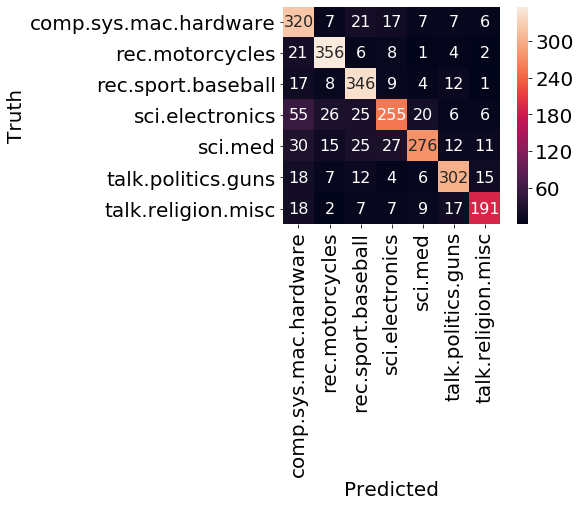

accuracy: 0.791795665634675


In [36]:
classify_and_plot(X_train, y_train, X_test, y_test)

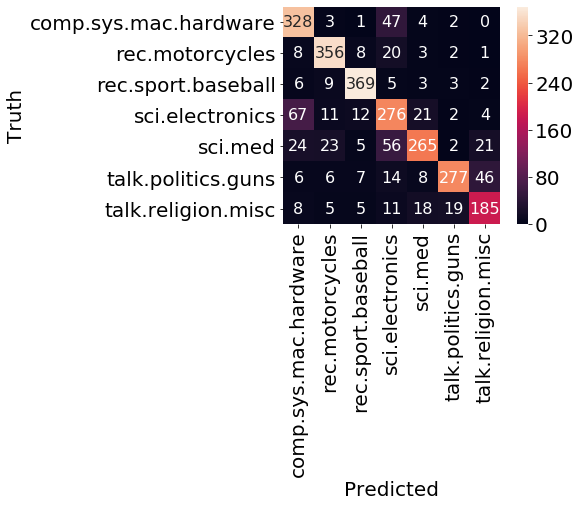

accuracy: 0.7956656346749226


In [37]:
classify_and_plot(X_train_svd, y_train, X_test_svd, y_test)

# Cross Validation

![alt text](https://kevinzakka.github.io/assets/knn/k-fold.png )



K-fold CV is the most popular type of cross validation.

* Thoroughly test your model and evaluate it more realistically
* Helps with tuning model hyperparameters


Stratified K-fold cross validation takes _**class imbalance**_ into account, ensuring all splits have equal representation of all of your classes. We will use this.

[Stratified K-fold CV in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

In [38]:
X = np.array(all_data.data)
y = all_data.target

In [39]:
from tqdm import tqdm # Arabic taqaddum (تقدّم)

from sklearn.model_selection import StratifiedKFold, KFold
# sklearn has nice functions to simplify this process

skf = StratifiedKFold(n_splits=5)

knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

def run_kf(knn, kf, X, y):
  """
  Arguments:
    - knn (sklearn.neighbors.KNeighborsClassifier): knn classifier 
    - skf (sklearn.model_selection._split.StratifiedKFold): stratified k fold splitter
    - X (np.ndarray): data
    - y (np.ndarray): labels
    
  Returns:
    - scores (list[float]): list of accuracy scores for each CV split
  """
  scores = []
  
  for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)
    knn.fit(X_train_svd, y_train)

    y_pred = knn.predict(X_test_svd)

    scores.append(accuracy_score(y_test, y_pred))

  return scores


In [40]:
scores = run_kf(knn, skf, X, y)

5it [00:24,  4.97s/it]


In [41]:
print('scores', scores)
print('mean score', np.mean(scores))
print('min score', min(scores))

scores [0.8733590733590734, 0.8531684698608965, 0.8415765069551777, 0.8537151702786377, 0.8635658914728682]
mean score 0.8570770223853307
min score 0.8415765069551777


In [42]:
# Why are these all significantly higher than the accuracy scores we got from before?
print('length of all data', len(all_data.data))
print('length of given training data', len(train_set.data))
print('length of given testing data', len(test_set.data))
print('percentage training data', len(train_set.data)/len(all_data.data))

length of all data 6465
length of given training data 3881
length of given testing data 2584
percentage training data 0.6003093580819799


In [ ]:
_, train_counts = np.unique(train_set.target, return_counts=True)
_, test_counts = np.unique(test_set.target, return_counts=True)


plt.figure(figsize=(24, 6))

plt.subplot(121)
plt.bar(train_set.target_names, train_counts)
plt.xticks(rotation=90)
plt.title('train')

plt.subplot(122)
plt.bar(test_set.target_names, test_counts)
plt.xticks(rotation=90)
plt.title('test')
plt.show()

It looks like they are properly stratified! So what gives?

The amount of training data is a factor, as when you use a 5-fold split, each iteration has a train-test split of 80-20, providing more training data than the provided training subset (which was split 60-40 train-test).

But if we change to a 2-fold split, with 50-50 train-test, it still does better...

It turns out that when you select the provided train/test subsets with sklearn's `fetch_20newsgroups` function, the split between the train and test set is based on messages from before and after a specific date. [source](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

Which way of splitting is better?

